In [1]:
import pandas as pd
import re
import networkx as nx
import csv
import matplotlib.pyplot as plt
import numpy as np
import markov_clustering as mc
import random
from scipy.stats import hypergeom

# Part 1 – Data collection
## 1.1) Explore information sources and compile the seed gene list:
a) Get the list of human genes (i.e. the **seed list**) involved in the disease **Cardiomyopathy, Dilated** from the dataset *“Curated gene-disease associations”* (from *https://www.disgenet.org/downloads*)

In [2]:
root = "C:/Users/clara/Documents/Bio/"
path = "C:/Users/clara/Documents/Bio/curated_gene_disease_associations.tsv"
curated_gene_desease_association_DF = pd.read_csv(path, sep = '\t', compression = 'infer')

In [3]:
cardio_DF = curated_gene_desease_association_DF.loc[curated_gene_desease_association_DF['diseaseId'] == 'C0007193']
print('Number of detected genes involved in the desease "Cardiomyopathy, Dilated": ', len(cardio_DF))
cardio_DF.head(5)

Number of detected genes involved in the desease "Cardiomyopathy, Dilated":  48


,geneId,geneSymbol,DSI,DPI,diseaseId,diseaseName,diseaseType,diseaseClass,diseaseSemanticType,score,EI,YearInitial,YearFinal,NofPmids,NofSnps,source
502,58,ACTA1,0.540,0.769,C0007193,"Cardiomyopathy, Dilated",group,C14,Disease or Syndrome,0.40,1.0,2006.0,2013.0,2,0,GENOMICS_ENGLAND
610,70,ACTC1,0.610,0.538,C0007193,"Cardiomyopathy, Dilated",group,C14,Disease or Syndrome,0.65,1.0,2006.0,2019.0,0,3,CTD_human
1414,153,ADRB1,0.555,0.769,C0007193,"Cardiomyopathy, Dilated",group,C14,Disease or Syndrome,0.58,1.0,1998.0,2019.0,1,0,CTD_human
1444,154,ADRB2,0.442,0.923,C0007193,"Cardiomyopathy, Dilated",group,C14,Disease or Syndrome,0.51,1.0,2002.0,2008.0,1,0,CTD_human
3663,355,FAS,0.372,0.923,C0007193,"Cardiomyopathy, Dilated",group,C14,Disease or Syndrome,0.51,1.0,1999.0,2007.0,1,0,CTD_human


In [4]:
seed_list = list(cardio_DF['geneId'])
print("List of Entrez genes:\n", *seed_list)

List of Entrez genes:
 58 70 153 154 355 356 472 948 1440 1482 1499 1756 1956 2194 2876 3688 4000 4306 4624 4625 4878 4879 5318 5663 5664 5879 5894 5973 6331 6389 6443 6462 6584 6648 6934 7112 7137 7139 7273 7350 7840 8313 10060 55759 64651 137735 150094 347273


In [5]:
print("List of gene symbols:\n", *list(cardio_DF['geneSymbol']))
seed_genes_symbols = list(cardio_DF['geneSymbol'])

List of gene symbols:
 ACTA1 ACTC1 ADRB1 ADRB2 FAS FASLG ATM CD36 CSF3 NKX2-5 CTNNB1 DMD EGFR FASN GPX1 ITGB1 LMNA NR3C2 MYH6 MYH7 NPPA NPPB PKP2 PSEN1 PSEN2 RAC1 RAF1 RENBP SCN5A SDHA SGCB SHBG SLC22A5 SOD2 TCF7L2 TMPO TNNI3 TNNT2 TTN UCP1 ALMS1 AXIN2 ABCC9 WDR12 CSRNP1 ABRA SIK1 CAVIN4


b) Check if gene symbols for all genes in the seed gene list are updated and approved on the *HGNC* website (from *https://www.genenames.org/tools/multi-symbol-checker/*)

In [6]:
# Upload this csv in the multi-symbol checker tool of the HGNC: 
cardio_DF['geneSymbol'].to_csv('gene_symbols.csv', index = False, header = False, line_terminator = ',')

In [7]:
cardio_DF['geneId'].to_csv('geneId.csv', index = False, header = False, line_terminator = ',')

The multi-symbol checker on the *HGNC* database reports that all the gene symbols in our seed list are updated and approved. Three of them match both an approved and an alias symbol, namely ***FAS***, ***RAC1*** and ***RAF1***

For each protein in our seed list we want to collect the following information from the *Uniprot* website:
* official (primary) **gene symbol** --> *Gene names (primary)*
* **Uniprot AC**, alphanumeric ‘accession number’ (a.k.a. ’Uniprot entry’) --> *Entry*
* **protein name** (the main one only, do not report the aliases)
* **Entrez Gene ID** (a.k.a. ‘GeneID’) --> *geneID* from disgenet
* very brief description of its function (keep it very short, i.e. max 20 words)
* notes related to the above information, if any and if relevant

**NOTE**: With regards to the gene symbol **TMPO** only the entry corresponding to the protein *Thymopoietin, isoforms alpha* (P42166) has been kept since its information on the *HGNG* only refer to this one and not to the isoform beta/gamma

In [8]:
path = root + "uniprot-list-with-ids.csv"
uniprot_DF = pd.read_csv(path, sep = '\t')
uniprot_DF['ProteinName'] = uniprot_DF['ProteinName'].str.split(r"\(|\[").str[0]

In [9]:
uniprot_DF[['GeneName','UniprotAC', 'ProteinName', 'GeneId']].head(5)

,GeneName,UniprotAC,ProteinName,GeneId
0,ACTA1,P68133,"Actin, alpha skeletal muscle",58
1,ACTC1,P68032,"Actin, alpha cardiac muscle 1",70
2,ADRB1,P08588,Beta-1 adrenergic receptor,153
3,ADRB2,P07550,Beta-2 adrenergic receptor,154
4,FAS,P25445,Tumor necrosis factor receptor superfamily mem...,355


## 1.2) Collect interaction data

a) For each seed gene, collect all binary protein interactions from the *Biogrid Human*.

In [10]:
biogrid_path = root + "BIOGRID.tab3.txt"
biogrid_full_DF = pd.read_csv(biogrid_path, sep = '\t', na_values='-', keep_default_na=True)
biogrid_full_DF.head()

C:\Users\clara\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (19,29,30,31,32,33,34) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,#BioGRID Interaction ID,Entrez Gene Interactor A,Entrez Gene Interactor B,BioGRID ID Interactor A,BioGRID ID Interactor B,Systematic Name Interactor A,Systematic Name Interactor B,Official Symbol Interactor A,Official Symbol Interactor B,Synonyms Interactor A,...,TREMBL Accessions Interactor B,REFSEQ Accessions Interactor B,Ontology Term IDs,Ontology Term Names,Ontology Term Categories,Ontology Term Qualifier IDs,Ontology Term Qualifier Names,Ontology Term Types,Organism Name Interactor A,Organism Name Interactor B
0,103,6416.0,2318,112315,108607,NaN,NaN,MAP2K4,FLNC,JNKK|JNKK1|MAPKK4|MEK4|MKK4|PRKMK4|SAPKK-1|SAP...,...,Q59H94,NP_001120959|NP_001449,NaN,NaN,NaN,NaN,NaN,NaN,Homo sapiens,Homo sapiens
1,117,84665.0,88,124185,106603,NaN,NaN,MYPN,ACTN2,CMD1DD|CMH22|MYOP|RCM4,...,Q59FD9|F6THM6,NP_001094|NP_001265272|NP_001265273,NaN,NaN,NaN,NaN,NaN,NaN,Homo sapiens,Homo sapiens
2,183,90.0,2339,106605,108625,NaN,NaN,ACVR1,FNTA,ACTRI|ACVR1A|ACVRLK2|ALK2|FOP|SKR1|TSRI,...,NaN,NP_002018,NaN,NaN,NaN,NaN,NaN,NaN,Homo sapiens,Homo sapiens
3,278,2624.0,5371,108894,111384,NaN,NaN,GATA2,PML,DCML|IMD21|MONOMAC|NFE1B,...,NaN,NP_150250|NP_150253|NP_150252|NP_150247|NP_150...,NaN,NaN,NaN,NaN,NaN,NaN,Homo sapiens,Homo sapiens
4,418,6118.0,6774,112038,112651,RP4-547C9.3,NaN,RPA2,STAT3,REPA2|RP-A p32|RP-A p34|RPA32,...,NaN,NP_644805|NP_003141|NP_001356447|NP_001356443|...,NaN,NaN,NaN,NaN,NaN,NaN,Homo sapiens,Homo sapiens


We select only the interactions among organisms being both *Homo Sapiens*

In [11]:
biogrid_full_DF = biogrid_full_DF[(biogrid_full_DF['Organism ID Interactor A'] == 9606) & (biogrid_full_DF['Organism ID Interactor B'] == 9606)]
biogrid_full_DF.astype({'Entrez Gene Interactor A': 'int64', 'Entrez Gene Interactor B': 'int64'})

,#BioGRID Interaction ID,Entrez Gene Interactor A,Entrez Gene Interactor B,BioGRID ID Interactor A,BioGRID ID Interactor B,Systematic Name Interactor A,Systematic Name Interactor B,Official Symbol Interactor A,Official Symbol Interactor B,Synonyms Interactor A,...,TREMBL Accessions Interactor B,REFSEQ Accessions Interactor B,Ontology Term IDs,Ontology Term Names,Ontology Term Categories,Ontology Term Qualifier IDs,Ontology Term Qualifier Names,Ontology Term Types,Organism Name Interactor A,Organism Name Interactor B
0,103,6416,2318,112315,108607,NaN,NaN,MAP2K4,FLNC,JNKK|JNKK1|MAPKK4|MEK4|MKK4|PRKMK4|SAPKK-1|SAP...,...,Q59H94,NP_001120959|NP_001449,NaN,NaN,NaN,NaN,NaN,NaN,Homo sapiens,Homo sapiens
1,117,84665,88,124185,106603,NaN,NaN,MYPN,ACTN2,CMD1DD|CMH22|MYOP|RCM4,...,Q59FD9|F6THM6,NP_001094|NP_001265272|NP_001265273,NaN,NaN,NaN,NaN,NaN,NaN,Homo sapiens,Homo sapiens
2,183,90,2339,106605,108625,NaN,NaN,ACVR1,FNTA,ACTRI|ACVR1A|ACVRLK2|ALK2|FOP|SKR1|TSRI,...,NaN,NP_002018,NaN,NaN,NaN,NaN,NaN,NaN,Homo sapiens,Homo sapiens
3,278,2624,5371,108894,111384,NaN,NaN,GATA2,PML,DCML|IMD21|MONOMAC|NFE1B,...,NaN,NP_150250|NP_150253|NP_150252|NP_150247|NP_150...,NaN,NaN,NaN,NaN,NaN,NaN,Homo sapiens,Homo sapiens
4,418,6118,6774,112038,112651,RP4-547C9.3,NaN,RPA2,STAT3,REPA2|RP-A p32|RP-A p34|RPA32,...,NaN,NP_644805|NP_003141|NP_001356447|NP_001356443|...,NaN,NaN,NaN,NaN,NaN,NaN,Homo sapiens,Homo sapiens
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696765,2875130,9564,9768,114934,115114,hCG_1980470,L5,BCAR1,KIAA0101,CAS|CAS1|CASS1|CRKAS|P130Cas,...,NaN,NP_001025160|NP_055551,NaN,NaN,NaN,NaN,NaN,NaN,Homo sapiens,Homo sapiens
696766,2875131,9564,65263,114934,122418,hCG_1980470,NaN,BCAR1,PYCRL,CAS|CAS1|CASS1|CRKAS|P130Cas,...,NaN,NP_001316795|NP_075566,NaN,NaN,NaN,NaN,NaN,NaN,Homo sapiens,Homo sapiens
696767,2875132,9564,79691,114934,122812,hCG_1980470,NaN,BCAR1,QTRTD1,CAS|CAS1|CASS1|CRKAS|P130Cas,...,NaN,NP_078914|NP_001243764|NP_001243765|NP_001243766,NaN,NaN,NaN,NaN,NaN,NaN,Homo sapiens,Homo sapiens
696768,2875133,9564,85465,114934,124549,hCG_1980470,NaN,BCAR1,EPT1,CAS|CAS1|CASS1|CRKAS|P130Cas,...,NaN,NP_277040,NaN,NaN,NaN,NaN,NaN,NaN,Homo sapiens,Homo sapiens


In [12]:
total_seed_list = set(biogrid_full_DF['Entrez Gene Interactor B']).union(set(biogrid_full_DF['Entrez Gene Interactor A']))
total_protein_symbol_list = set(biogrid_full_DF['Official Symbol Interactor B']).union(set(biogrid_full_DF['Official Symbol Interactor A']))

In [13]:
tot_non_seed_pr_list = total_protein_symbol_list.difference(seed_genes_symbols)
len(total_protein_symbol_list - tot_non_seed_pr_list)
for i in seed_genes_symbols:
    if i not in total_protein_symbol_list:
        print(i)

CAVIN4


In [14]:
print(len(total_seed_list.difference(seed_list)), len(tot_non_seed_pr_list))

19045 19044


We also check if all the seed genes are also present in the *Biogrid* database:

In [15]:
print('Seed genes extracted from DisGeNET: ', len(seed_list))
print('Seed genes also present in Biogrid: ', len(total_seed_list.intersection(seed_list)))

Seed genes extracted from DisGeNET:  48
Seed genes also present in Biogrid:  48


In [16]:
biogrid_seed_genes_interactions = biogrid_full_DF[((biogrid_full_DF['Entrez Gene Interactor A'].isin(seed_list)) | (biogrid_full_DF['Entrez Gene Interactor B'].isin(seed_list)) )]
print("Total number of interactions involving at least one seed gene: ", biogrid_seed_genes_interactions.shape[0])

Total number of interactions involving at least one seed gene:  12081


In [17]:
seed_genes_interactions_ONLY = biogrid_seed_genes_interactions[((biogrid_seed_genes_interactions['Entrez Gene Interactor A'].isin(seed_list)) & (biogrid_seed_genes_interactions['Entrez Gene Interactor B'].isin(seed_list)) )]
print("Total number of interactions involving only seed genes: ", seed_genes_interactions_ONLY.shape[0])

Total number of interactions involving only seed genes:  180


In [18]:
total_geneId_list = set(biogrid_seed_genes_interactions['Entrez Gene Interactor B']).union(set(biogrid_seed_genes_interactions['Entrez Gene Interactor A']))
not_seed_genes = total_geneId_list.difference(seed_list)

total_protein_symbol_list = set(biogrid_seed_genes_interactions['Official Symbol Interactor B']).union(set(biogrid_seed_genes_interactions['Official Symbol Interactor A']))
not_seed_genes_symbols = total_protein_symbol_list.difference(seed_genes_symbols)

print("Numeber of genes involved in the PPI interactions with the seed genes: ", len(not_seed_genes), len(not_seed_genes_symbols))

Numeber of genes involved in the PPI interactions with the seed genes:  4886 4887


In [19]:
for i in seed_genes_symbols:
    if i not in total_protein_symbol_list:
        print(i)

CAVIN4


The protein *CAVIN4* seems to compare in no interaction, but to be sure we filter the table by its GeneId:

In [20]:
cavin4_ID = uniprot_DF.loc[uniprot_DF['GeneName']=='CAVIN4', 'GeneId'].item()
cavin4_ID

347273

In [21]:
biogrid_seed_genes_interactions[(biogrid_seed_genes_interactions['Entrez Gene Interactor A']==cavin4_ID) | (biogrid_seed_genes_interactions['Entrez Gene Interactor B']==cavin4_ID)]

,#BioGRID Interaction ID,Entrez Gene Interactor A,Entrez Gene Interactor B,BioGRID ID Interactor A,BioGRID ID Interactor B,Systematic Name Interactor A,Systematic Name Interactor B,Official Symbol Interactor A,Official Symbol Interactor B,Synonyms Interactor A,...,TREMBL Accessions Interactor B,REFSEQ Accessions Interactor B,Ontology Term IDs,Ontology Term Names,Ontology Term Categories,Ontology Term Qualifier IDs,Ontology Term Qualifier Names,Ontology Term Types,Organism Name Interactor A,Organism Name Interactor B
118129,738323,347273.0,351,131419,106848,NaN,NaN,MURC,APP,CAVIN4|cavin-4,...,B4DGD0|E9PG40|B4DJT9,NP_958817|NP_958816|NP_001191230|NP_001191231|...,NaN,NaN,NaN,NaN,NaN,NaN,Homo sapiens,Homo sapiens
566648,2714823,705.0,347273,107167,131419,RP5-973N23.2,NaN,BYSL,MURC,BYSTIN,...,NaN,NP_001018126,NaN,NaN,NaN,NaN,NaN,NaN,Homo sapiens,Homo sapiens
584673,2732848,55093.0,347273,120405,131419,NaN,NaN,WDYHV1,MURC,C8orf32,...,NaN,NP_001018126,NaN,NaN,NaN,NaN,NaN,NaN,Homo sapiens,Homo sapiens
591215,2739390,347273.0,84619,131419,124150,NaN,RP4-583P15.3,MURC,ZGPAT,CAVIN4|cavin-4,...,NaN,NP_001076582|NP_115916|NP_001182582|NP_0011825...,NaN,NaN,NaN,NaN,NaN,NaN,Homo sapiens,Homo sapiens
625353,2784767,2547.0,347273,108822,131419,CTA-216E10.7,NaN,XRCC6,MURC,CTC75|CTCBF|G22P1|KU70|ML8|TLAA,...,NaN,NP_001018126,NaN,NaN,NaN,NaN,NaN,NaN,Homo sapiens,Homo sapiens
628391,2787805,3159.0,347273,109402,131419,RP11-513I15.2,NaN,HMGA1,MURC,HMG-R|HMGA1A|HMGIY,...,NaN,NP_001018126,NaN,NaN,NaN,NaN,NaN,NaN,Homo sapiens,Homo sapiens


According to the *BioGrid* database, the official symbol for the gene 347273 is *MURC*, whereas *CAVIN4* is one of its aliases. Thus, we modify our seed list to meet this convention

In [22]:
seed_genes_symbols.append('MURC')
seed_genes_symbols.remove('CAVIN4')

total_protein_symbol_list = set(biogrid_seed_genes_interactions['Official Symbol Interactor B']).union(set(biogrid_seed_genes_interactions['Official Symbol Interactor A']))
not_seed_genes_symbols = total_protein_symbol_list.difference(seed_genes_symbols)

print("Numeber of genes involved in the PPI interactions with the seed genes: ", len(not_seed_genes_symbols))

Numeber of genes involved in the PPI interactions with the seed genes:  4886


Select the interactions among the non-seed genes from the full dataset

In [23]:
biogrid_non_seed_genes_interactions_ONLY = biogrid_full_DF[(biogrid_full_DF['Official Symbol Interactor A'].isin(not_seed_genes_symbols)) & (biogrid_full_DF['Official Symbol Interactor B'].isin(not_seed_genes_symbols)) ]
print("Total number of interactions involving only seed genes: ", biogrid_non_seed_genes_interactions_ONLY.shape[0])

Total number of interactions involving only seed genes:  259756


In [24]:
print("In total, the PPI interactions collected are ", biogrid_non_seed_genes_interactions_ONLY.shape[0]+biogrid_seed_genes_interactions.shape[0])

In total, the PPI interactions collected are  271837


b) Merge in a single table the data gathered from *BioGrid* and remove useless columns

In [25]:
ppi_df = pd.concat([biogrid_seed_genes_interactions, biogrid_non_seed_genes_interactions_ONLY])
ppi_df.shape

(271837, 37)

We remove: the four columns reletad to organism of each interactor, since we selected only rows corresponding to *Homo Sapiens*, the column *'Tags'* that contains null values and the column *'Source Database'* that is always equal to *BIOGRID*

In [26]:
ppi_df.drop(columns=['Organism Name Interactor A', 'Organism Name Interactor B', 'Organism ID Interactor A', 'Organism ID Interactor B', 'Source Database', 'Tags'], inplace=True)

In [27]:
ppi_df['Throughput'].unique()

array(['Low Throughput', 'High Throughput',
       'High Throughput|Low Throughput'], dtype=object)

In [28]:
tot = ppi_df.shape[0]
for col in ppi_df:
    nan = ppi_df[col].isna().sum()
    print(col, nan, "\t", round(nan/tot*100, 2), '%\t', ppi_df[col].nunique())

#BioGRID Interaction ID 0 	 0.0 %	 271837
Entrez Gene Interactor A 0 	 0.0 %	 4574
Entrez Gene Interactor B 0 	 0.0 %	 4905
BioGRID ID Interactor A 0 	 0.0 %	 4574
BioGRID ID Interactor B 0 	 0.0 %	 4905
Systematic Name Interactor A 194979 	 71.73 %	 1367
Systematic Name Interactor B 194766 	 71.65 %	 1462
Official Symbol Interactor A 0 	 0.0 %	 4574
Official Symbol Interactor B 0 	 0.0 %	 4905
Synonyms Interactor A 14939 	 5.5 %	 4154
Synonyms Interactor B 15293 	 5.63 %	 4420
Experimental System 0 	 0.0 %	 27
Experimental System Type 0 	 0.0 %	 2
Author 0 	 0.0 %	 18998
Publication Source 0 	 0.0 %	 20068
Throughput 0 	 0.0 %	 3
Score 224406 	 82.55 %	 29908
Modification 264601 	 97.34 %	 18
Qualifications 152254 	 56.01 %	 6250
SWISS-PROT Accessions Interactor A 586 	 0.22 %	 4535
TREMBL Accessions Interactor A 126099 	 46.39 %	 2180
REFSEQ Accessions Interactor A 183 	 0.07 %	 4560
SWISS-PROT Accessions Interactor B 692 	 0.25 %	 4831
TREMBL Accessions Interactor B 127274 	 46.82 %

Some columns also have a very high percentage of missing values (higher than 90%), namely: *Modification, Ontology Term IDs, Ontology Term Names, Ontology Term Categories, Ontology Term Qualifier IDs, Ontology Term Qualifier Names, Ontology Types*. For this reason we can also remove them from the final database.

In [29]:
ppi_df.drop(columns=['Modification', 'Ontology Term IDs', 'Ontology Term Names', 'Ontology Term Categories', 'Ontology Term Qualifier IDs', 'Ontology Term Qualifier Names', 'Ontology Term Types'], inplace=True)

In [30]:
ppi_df.to_csv('PPIs.csv', index = False, header = True, line_terminator = '\n', sep=',')

c) Summarize the main results in a table reporting:
    1. no. of seed genes collected in Disgenet and no. of seed genes found in Biogrid (some seed genes may be missing in the Biogrid);
    2. total no. of interacting genes/proteins found, including seed genes;
    3. total no. of interactions found.

In [31]:
ppi_summary = {
    "seed_genes (DISGNET)": len(seed_list),
    "seed_genes (BIOGRID)": len(seed_list),
    "interacting proteins": len(seed_list) + len(not_seed_genes),
    "interactions": biogrid_non_seed_genes_interactions_ONLY.shape[0]+biogrid_seed_genes_interactions.shape[0]
}
pd.DataFrame.from_dict(ppi_summary, orient='index', columns = ['Tot number'])

,Tot number
seed_genes (DISGNET),48
seed_genes (BIOGRID),48
interacting proteins,4934
interactions,271837


## 1.3) Arrange interaction data
a) **Seed genes interactome**: interactions that involve seed genes only

In [32]:
add_uniprotAC_A = seed_genes_interactions_ONLY.join(uniprot_DF[['UniprotAC', 'GeneId']].set_index('GeneId'), on = 'Entrez Gene Interactor A').rename(columns={"UniprotAC": "UniprotAC Interactor A"})
add_uniprotAC_B = add_uniprotAC_A.join(uniprot_DF[['UniprotAC', 'GeneId']].set_index('GeneId'), on = 'Entrez Gene Interactor B').rename(columns={"UniprotAC": "UniprotAC Interactor B"})
final_ppi_seed_genes = add_uniprotAC_B[['Official Symbol Interactor A', 'Official Symbol Interactor B', 'UniprotAC Interactor A' ,'UniprotAC Interactor B' ]].drop_duplicates().reset_index(drop=True)
final_ppi_seed_genes.head()

,Official Symbol Interactor A,Official Symbol Interactor B,UniprotAC Interactor A,UniprotAC Interactor B
0,FASN,FASN,P49327,P49327
1,PSEN1,CTNNB1,P49768,P35222
2,FAS,FASLG,P25445,P48023
3,EGFR,CTNNB1,P00533,P35222
4,ATM,ATM,Q13315,Q13315


In [33]:
print('Total number of interacting couple of proteins among the seed list: ', final_ppi_seed_genes.shape[0])

Total number of interacting couple of proteins among the seed list:  59


In [34]:
final_ppi_seed_genes.to_csv('seed_genes_interactome.csv', index = False, header = True, line_terminator = '\n', sep=',')

In [35]:
# same as above, but keeping the BioGRID Interaction ID
add_uniprotAC_A = seed_genes_interactions_ONLY.join(uniprot_DF[['UniprotAC', 'GeneId']].set_index('GeneId'), on = 'Entrez Gene Interactor A').rename(columns={"UniprotAC": "UniprotAC Interactor A"})
add_uniprotAC_B = add_uniprotAC_A.join(uniprot_DF[['UniprotAC', 'GeneId']].set_index('GeneId'), on = 'Entrez Gene Interactor B').rename(columns={"UniprotAC": "UniprotAC Interactor B"})
final_ppi_seed_genes = add_uniprotAC_B[['#BioGRID Interaction ID','Official Symbol Interactor A', 'Official Symbol Interactor B', 'UniprotAC Interactor A' ,'UniprotAC Interactor B' ]]
final_ppi_seed_genes.head()

,#BioGRID Interaction ID,Official Symbol Interactor A,Official Symbol Interactor B,UniprotAC Interactor A,UniprotAC Interactor B
448,19043,FASN,FASN,P49327,P49327
6851,243863,PSEN1,CTNNB1,P49768,P35222
7227,244313,FAS,FASLG,P25445,P48023
7533,244745,EGFR,CTNNB1,P00533,P35222
7796,245113,ATM,ATM,Q13315,Q13315


In [36]:
final_ppi_seed_genes.to_csv('seed_genes_interactome_with_BiogridID.csv', index = False, header = True, line_terminator = '\n', sep=',')

b) **Disease interactome**: all proteins interacting with at least one seed gene

We first need to retrieve the *UniprotAC* identifier of all the non-seed genes involved in the selected interactions. We can accomplish this through the *Retrieve Id/Mapping* tool on the *Uniprot* website.

In [37]:
# mapping based on gene symbols -> 4865 out of 4887 
with open("non_seed_genes_symbol.csv",'w') as file:
    writer = csv.writer(file)
    writer.writerow(list(not_seed_genes_symbols))

The mapping tool reported that 4864 out of 4886 genes were successfully mapped to 4959 UniProtKB IDs, which means that 22 proteins are not mapped in *Uniprot*.

In [38]:
uniprot_not_seed_mapping = pd.read_csv(root + "uniprot-not-seed-symbol.csv", sep = '\t', na_values='-', keep_default_na=True)
uniprot_not_seed_mapping['Entry'].nunique()

4959

In [39]:
uniprot_not_seed_mapping['GeneName'].nunique()

4874

In [40]:
not_mapped = [i for i in not_seed_genes_symbols if i not in uniprot_not_seed_mapping['GeneName'].unique()]
print('The following proteins are also not been mapped to their UniprotAC identifier: \n', *not_mapped)

The following proteins are also not been mapped to their UniprotAC identifier: 
 RPL17-C18orf32 HIST1H2AB HIST1H4H HBA1 HIST1H4J HIST1H2BE LOC400499 HIST1H2BF HIST1H2BC HIST1H4L COX3 HIST1H2BG


After a double check on the *Uniprot* website, we found out that the proteins listed above are unreviewed, therefore we keep them not mapped

In [41]:
print(uniprot_not_seed_mapping.shape[0])
nan = np.nan
for gene in not_mapped:
    df = pd.DataFrame([[nan, gene]], columns=['Entry', 'GeneName'])
    uniprot_not_seed_mapping = uniprot_not_seed_mapping.append(df, ignore_index=True)
print(uniprot_not_seed_mapping.shape[0])

5021
5033


In [42]:
uniprot_not_seed_mapping.rename(columns={'Entry' :'UniprotAC'}, inplace = True)
uniprot_full = pd.concat([uniprot_DF[['UniprotAC', 'GeneName']], uniprot_not_seed_mapping], ignore_index=True)
print(uniprot_full.shape[0])
uniprot_full.head()

5081


,UniprotAC,GeneName
0,P68133,ACTA1
1,P68032,ACTC1
2,P08588,ADRB1
3,P07550,ADRB2
4,P25445,FAS


Another problem is that some GeneName are associated to multiple UniprotAC identifiers, namely:

In [43]:
g = uniprot_full.groupby('GeneName')['UniprotAC'].apply(list) 
g = pd.DataFrame(g)
agg_uniprot = g[g['UniprotAC'].str.len() > 1]

In [44]:
agg_uniprot.reset_index(inplace=True)
agg_uniprot.head()

,GeneName,UniprotAC
0,ACAT1,"[P24752, P35610]"
1,ACAT2,"[O75908, Q9BWD1]"
2,ADRA1A,"[P25100, P35348]"
3,AIP,"[O00170, Q9NWT8]"
4,AK3,"[P27144, Q9UIJ7]"


In [45]:
multiple_geneName = list(agg_uniprot['GeneName'])
len(multiple_geneName)

130

We remove from the *Uniprot_full* db the corresponding rows and we add the aggregation table defined above

In [46]:
uniprot_full = uniprot_full[-uniprot_full['GeneName'].isin(multiple_geneName)]
uniprot_full = uniprot_full.append(agg_uniprot)
uniprot_full.shape

(4934, 2)

In [47]:
uniprot_full.to_csv('uniprot_full.csv', index = False, header = True, line_terminator = '\n', sep=',')

Now we can join the table with all the interactions with the uniprot table

In [48]:
ppi_df = ppi_df[['Official Symbol Interactor A', 'Official Symbol Interactor B']].drop_duplicates().reset_index(drop=True)
print(ppi_df.shape)
ppi_df.head()

(212556, 2)


,Official Symbol Interactor A,Official Symbol Interactor B
0,ADRB1,GIPC1
1,PSEN2,CAPN1
2,CAPN3,TTN
3,MAGI1,CTNNB1
4,DCN,EGFR


In [49]:
ppi_df = ppi_df.merge(uniprot_full, left_on ='Official Symbol Interactor A', right_on='GeneName', how = 'left', left_index=False, right_index=False).rename(columns={"UniprotAC": "UniprotAC Interactor A"})
ppi_df = ppi_df.drop(columns = ['GeneName'])
ppi_df = ppi_df.merge(uniprot_full, left_on ='Official Symbol Interactor B', right_on='GeneName', how = 'left', left_index=False, right_index=False).rename(columns={"UniprotAC": "UniprotAC Interactor B"})
ppi_df = ppi_df.drop(columns = ['GeneName'])

print(ppi_df.shape)
ppi_df.head(10)

(212556, 4)


,Official Symbol Interactor A,Official Symbol Interactor B,UniprotAC Interactor A,UniprotAC Interactor B
0,ADRB1,GIPC1,P08588,O14908
1,PSEN2,CAPN1,P49810,P07384
2,CAPN3,TTN,P20807,Q8WZ42
3,MAGI1,CTNNB1,"[Q6P9H4, Q96QZ7]",P35222
4,DCN,EGFR,P07585,P00533
5,SUMO1,FAS,P63165,P25445
6,FLNA,ITGB1,P21333,P05556
7,LMNA,LMNB1,P02545,P20700
8,LMNA,SREBF1,P02545,P36956
9,LMNA,NARF,P02545,"[Q8WVD3, Q9UHQ1]"


Since not all the gene symbols are mapped, we still have some null values in the columns corresponding to the UniprotAC identifier, namely:

In [50]:
print("Null values corresponding to the UniprotAC Interactor A: ", ppi_df['UniprotAC Interactor A'].isnull().sum())
print("Null values corresponding to the UniprotAC Interactor B: ", ppi_df['UniprotAC Interactor B'].isnull().sum())

Null values corresponding to the UniprotAC Interactor A:  1832
Null values corresponding to the UniprotAC Interactor B:  908


In [51]:
ppi_df.to_csv('desease_interactome.csv', index = False, header = True, line_terminator = '\n', sep=',')

In [52]:
tot_pr = set(ppi_df['Official Symbol Interactor B']).union(set(ppi_df['Official Symbol Interactor A']))
len(tot_pr)

4934

In [53]:
with open("protein_list_ENRICHER.csv",'w') as file:
    file.write("\n".join(map(str, tot_pr)))

## 1.4) Enrichment analysis
The following tables represent the results we obtained performing the enrichment analysis on the *Enrichr* website:

a) **GO Biological Process 2018**

In [54]:
go_bp = pd.read_csv(root + "GO_Biological_Process_2018_table.txt", sep = '\t')
go_bp.head(10)

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,viral process (GO:0016032),155/220,1.032337e-46,5.268018e-43,0,0,2.855879,302.400758,RPL4;RPL5;RPL30;RPL3;NUP107;RPL32;NUP188;RPL31...
1,regulation of apoptotic process (GO:0042981),378/815,4.125531e-43,1.052629e-39,0,0,1.880031,183.479691,TNFRSF6B;TRIO;ARL6IP1;ARAF;PHB2;CCAR2;IFIT3;AQ...
2,positive regulation of gene expression (GO:001...,362/771,9.265969e-43,1.576141e-39,0,0,1.903203,184.201112,RB1;ATF2;RPL5;APP;CNTF;PID1;EIF4A3;ELK1;ACTB;A...
3,cellular protein modification process (GO:0006...,419/1001,1.222720e-34,1.559885e-31,0,0,1.696722,132.491650,ARAF;DCAF8;DCAF4;PSMD6;PSMD7;TBK1;PPP4R2;PSMD4...
4,protein modification by small protein removal ...,157/261,1.947478e-34,1.987596e-31,0,0,2.438316,189.265403,OTUD5;TRRAP;KEAP1;UBE2D1;TOMM20;ACTB;CDC20;YY1...
5,"mRNA splicing, via spliceosome (GO:0000398)",157/261,1.947478e-34,1.656330e-31,0,0,2.438316,189.265403,DBR1;EIF4A3;HNRNPU;GPATCH1;WDR83;HNRNPR;CWC27;...
6,mRNA processing (GO:0006397),166/283,1.953500e-34,1.424101e-31,0,0,2.377675,184.551027,DBR1;CCNH;EIF4A3;HNRNPU;GPATCH1;WDR83;HNRNPR;C...
7,"RNA splicing, via transesterification reaction...",146/236,4.808711e-34,3.067357e-31,0,0,2.507678,192.382667,DBR1;EIF4A3;HNRNPU;GPATCH1;WDR83;HNRNPR;CWC27;...
8,transmembrane receptor protein tyrosine kinase...,206/396,3.421880e-32,1.940206e-29,0,0,2.108642,152.776465,CYFIP2;CYFIP1;NCKAP1;SLA2;ACTB;BAIAP2L1;UBASH3...
9,regulation of transcription from RNA polymeras...,560/1478,6.315189e-32,3.222641e-29,0,0,1.535835,110.333996,RB1;ATF2;PID1;MAML2;EHMT2;SERPINE1;HNRNPU;ENO1...


b) **GO Molecular Function 2018**

In [55]:
go_mf = pd.read_csv(root + "GO_Molecular_Function_2018_table.txt", sep = '\t')
go_mf.head(10)

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,RNA binding (GO:0003723),728/1387,1.417229e-118,1.631231e-115,0,0,2.127579,577.332143,RPL4;RPL5;RPL30;SLC4A1AP;TES;RPL3;TFRC;RPL32;P...
1,cadherin binding (GO:0045296),211/313,4.910198e-58,2.825819e-55,0,0,2.732555,360.584236,TES;ENO1;RPL6;CRKL;GOLGA2;PCMT1;BAIAP2L1;MPRIP...
2,protein kinase binding (GO:0019901),259/495,7.812540e-41,2.997411e-38,0,0,2.120926,195.868019,ATF2;ERRFI1;CCNK;ARAF;ACTB;GOLGA2;TCL1A;CHEK2;...
3,kinase binding (GO:0019900),226/418,1.162173e-38,3.344153e-36,0,0,2.191609,191.432506,RB1;ATF2;ERRFI1;CCNK;ACTB;GOLGA2;TCL1A;CHEK2;P...
4,ubiquitin-like protein ligase binding (GO:0044...,167/297,1.490565e-31,3.431281e-29,0,0,2.279244,161.782998,RB1;RPL5;SMC6;UBE2Z;CLU;UBE2L3;ACTG1;HERC2;TRI...
5,ubiquitin protein ligase binding (GO:0031625),161/284,5.045209e-31,9.678392e-29,0,0,2.297938,160.308088,RB1;RPL5;SMC6;UBE2Z;CLU;UBE2L3;ACTG1;HERC2;TRI...
6,protein kinase activity (GO:0004672),238/513,2.262609e-27,3.720376e-25,0,0,1.880574,115.379385,CCNK;ARAF;CCNC;RPS6KA3;TBK1;AKT2;CHEK2;RPS6KA2...
7,actin binding (GO:0003779),133/254,1.472366e-21,2.118366e-19,0,0,2.122505,101.811094,CYFIP1;AVIL;WIPF2;WIPF3;HNRNPU;ABRA;EPS8;MAEA;...
8,protein serine/threonine kinase activity (GO:0...,172/368,1.598006e-20,2.043672e-18,0,0,1.894574,86.360244,MYLK2;CCNK;CCNT2;CCNT1;CCNH;ARAF;CCNC;RPS6KA3;...
9,purine ribonucleoside triphosphate binding (GO...,177/396,1.445062e-18,1.663266e-16,0,0,1.811794,74.425581,EIF4A3;RASEF;HNRNPU;TUBB6;STK11;GNAT2;TUBB3;AK...


c) **GO Cellular Component 2018**

In [56]:
go_cc = pd.read_csv(root + "GO_Cellular_Component_2018_table.txt", sep = '\t')
go_cc.head(10)

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,focal adhesion (GO:0005925),243/356,1.978364e-68,8.823505e-66,0,0,2.766860,431.335475,RPL4;CYFIP1;RPL5;MDC1;NCKAP1;RPL30;TES;RPL3;RP...
1,nucleolus (GO:0005730),326/676,1.685051e-41,3.757663e-39,0,0,1.954797,183.524578,RPL4;EIF4A2;RPL5;RPL3;SMARCB1;POP1;EIF4A3;FOXI...
2,nuclear body (GO:0016604),292/618,3.603342e-35,5.356968e-33,0,0,1.915249,151.895742,RB1;MDC1;EHMT2;GFI1;GPATCH2;RAPH1;HNRNPU;SMC6;...
3,cytosolic part (GO:0044445),107/159,6.958922e-30,7.759198e-28,0,0,2.727831,183.139849,RPL4;RPL5;RPL30;RPL3;RPL32;RPL31;IFIT5;AHR;RPL...
4,nuclear chromosome part (GO:0044454),195/392,2.735695e-27,2.440240e-25,0,0,2.016413,123.330672,SMARCB1;TRRAP;EHMT2;CCAR2;ACTB;KAT5;MYC;TP63;M...
5,mitochondrion (GO:0005739),400/1026,1.521915e-25,1.131290e-23,0,0,1.580314,90.306522,ARAF;ATP5C1;DCAF8;ABAT;PHB2;GCSH;LACTB;MPV17;G...
6,cytoskeleton (GO:0005856),236/520,1.754894e-25,1.118118e-23,0,0,1.839668,104.865171,AVIL;IFIT5;ACTB;ABRA;RASSF1;BAIAP2L1;MPRIP;OPH...
7,actin cytoskeleton (GO:0015629),152/294,1.040282e-23,5.799575e-22,0,0,2.095690,110.903858,AVIL;WIPF2;SPPL2B;WIPF3;IFIT5;ACTB;ABRA;AMOT;A...
8,chromatin (GO:0000785),150/296,2.717672e-22,1.346758e-20,0,0,2.054142,102.002712,RB1;SMARCB1;KDM1A;ICE2;EHMT2;NUCKS1;PARK7;SMC3...
9,nuclear speck (GO:0016607),149/296,8.700504e-22,3.880425e-20,0,0,2.040447,98.948419,EHMT2;GPATCH2;JADE1;HNRNPU;NR3C1;EFTUD2;ALKBH5...


d) **KEGG Pathways Human 2019**

In [57]:
kegg = pd.read_csv(root + "KEGG_2019_Human_table.txt", sep = '\t')
kegg.head(10)

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,Viral carcinogenesis,141/201,3.062108e-42,9.431291e-40,0,0,2.843504,271.809081,RB1;ATF2;GTF2B;HDAC11;UBE3A;RBPJ;CDC20;CCND3;C...
1,Pathways in cancer,254/530,6.522646e-32,1.004488e-29,0,0,1.942624,139.494845,RB1;ARAF;KEAP1;ELK1;CRKL;RASSF1;EDNRB;FRAT2;MY...
2,Focal adhesion,126/199,5.540925e-31,5.688683e-29,0,0,2.566542,178.805764,MYLK2;ITGA2B;TNC;ELK1;ACTB;ARHGAP35;CRKL;ACTG1...
3,ErbB signaling pathway,71/85,3.833314e-30,2.951652e-28,0,0,3.385870,229.337916,GSK3B;ARAF;CBLB;PIK3CB;AREG;ELK1;CRKL;MYC;AKT2...
4,Human papillomavirus infection,173/330,9.893664e-28,6.094497e-26,0,0,2.125020,132.134778,RB1;MAML2;ITGA2B;TNC;PPP2R2A;UBE3A;RBPJ;TNF;CC...
5,Protein processing in endoplasmic reticulum,106/165,4.779718e-27,2.453589e-25,0,0,2.604071,157.820788,UBE2D2;UBE2D1;FBXO6;CAPN1;MAP3K5;SEC63;SKP1;PD...
6,Spliceosome,92/134,6.834717e-27,3.007276e-25,0,0,2.783004,167.669838,ISY1;TCERG1;RBM25;DDX46;EIF4A3;DDX42;HNRNPU;PR...
7,Regulation of actin cytoskeleton,126/214,1.179922e-26,4.542701e-25,0,0,2.386644,142.486850,CYFIP2;CYFIP1;NCKAP1;MYLK2;CHRM5;ITGA2B;ARAF;A...
8,Human immunodeficiency virus 1 infection,125/212,1.558635e-26,5.333997e-25,0,0,2.390039,142.024252,TNF;CRKL;TBK1;AKT2;CFL2;CHEK1;CFL1;AP1S2;AP1S1...
9,Chronic myeloid leukemia,63/76,1.609993e-26,4.958778e-25,0,0,3.360143,199.562217,RB1;ARAF;PIK3CB;CRKL;IKBKB;MECOM;CCND1;MYC;AKT...


# Part 2 – Data analysis
## 2.1) Calculate the main network measures for the disease interactome
a) **Global measures** of the deseas interactome

In [58]:
G = nx.from_pandas_edgelist(ppi_df[['Official Symbol Interactor A','Official Symbol Interactor B']], source='Official Symbol Interactor A', target='Official Symbol Interactor B')

In [59]:
measures = {'Nr. nodes' : G.number_of_nodes(),
            'Nr. links' : G.number_of_edges(),
            'Nr. connected components' : nx.number_connected_components(G),
            'Nr. isolated nodes' : len(list(nx.isolates(G))),
            'Average path length': 2.3439362693165022, #nx.average_shortest_path_length(G), 
            'Average degree' : sum([v for k, v in G.degree()])/G.number_of_nodes(), 
            'Average clustering coefficient' : nx.average_clustering(G),
            'Network diameter' : 5, #nx.diameter(G), 
            'Network radius' : 3, #nx.radius(G), 
            'Centralization' : max([v for k, v in G.degree()])/(G.number_of_nodes()-1) - nx.density(G)}

In [60]:
pd.options.display.float_format = lambda x : '{:.0f}'.format(x) if round(x,0) == x else '{:,.2f}'.format(x)
global_measures = pd.DataFrame.from_dict(measures, orient='index', columns=['Value'])
global_measures.index.name='Global Measure'
global_measures

,Value
Global Measure,
Nr. nodes,4934
Nr. links,196283
Nr. connected components,1
Nr. isolated nodes,0
Average path length,2.34
Average degree,79.56
Average clustering coefficient,0.19
Network diameter,5
Network radius,3


In [61]:
global_measures.to_csv('global_measures.csv', index = True, header = True, line_terminator = ',')

b) **Local measures** of the desease interactome
Since we found out that our interactome is composed by just one connected component, we only need to calculate the local measures of each node in the network:

In [62]:
#nx.set_node_attributes(G, G.degree(), 'Node degree')  
#nx.set_node_attributes(G, nx.betweenness_centrality(G), "Betweenness centrality")
#nx.set_node_attributes(G, nx.eigenvector_centrality(G), "Eigenvector centrality")
#nx.set_node_attributes(G, nx.closeness_centrality(G), "Closeness centrality")

#local_measures = pd.DataFrame(index=G.nodes())
#local_measures['Node degree'] = [d for n, d in G.degree()] 
#local_measures['Betweenness centrality'] = pd.Series(nx.get_node_attributes(G, 'Betweenness centrality'))
#local_measures['Eigenvector centrality'] = pd.Series(nx.get_node_attributes(G, 'Eigenvector centrality'))
#local_measures['Closeness centrality'] = pd.Series(nx.get_node_attributes(G, 'Closeness centrality'))
#local_measures['Betweenness/Degree Ratio'] = local_measures['Betweenness centrality']/local_measures['Node degree']
#local_measures.index.name='Gene'

#local_measures.to_csv('local_measures.csv', index = True, header = True)

local_measures = pd.read_csv(root + 'local_measures.csv', sep=',')
local_measures.head()

,Gene,Node degree,Betweenness centrality,Eigenvector centrality,Closeness centrality,Betweenness/Degree Ratio
0,ADRB1,9,0.00,0.00,0.35,0.00
1,GIPC1,47,0.00,0.00,0.44,0.00
2,PSEN2,65,0.00,0.00,0.42,0.00
3,CAPN1,76,0.00,0.01,0.45,0.00
4,CAPN3,24,0.00,0.00,0.37,0.00


## 2.2) Find disease modules via the Markov Clustering method

In order to identify the desease modules, we run the MCL algorithm on the adjacency matrix of the graph representation of the desease interactome and retrieve the clusters.

In [63]:
result = mc.run_mcl(nx.to_scipy_sparse_matrix(G))           
clusters = mc.get_clusters(result) 

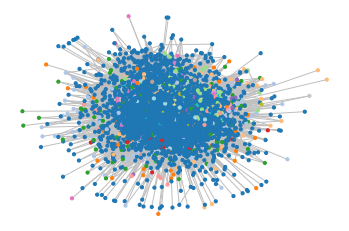

In [80]:
#positions = {i:(random.random() * 2 - 1, random.random() * 2 - 1) for i in range(G.number_of_nodes())}
mc.draw_graph(nx.to_scipy_sparse_matrix(G), clusters, node_size=10, with_labels=False, edge_color="silver")

We tune the **inflation** hyperparameter by determining the value that gives the highest **modularity measure *Q***, i.e. the fraction of graph edges which belong to a cluster minus the fraction expected due to random chance.

In [ ]:
## This takes an infinity of time!!! -> can be not run

# perform clustering using different inflation values from 1.5 and 2.5
# for each clustering run, calculate the modularity
matrix = nx.to_scipy_sparse_matrix(G)
for inflation in [i / 10 for i in range(15, 26)]:
    result = mc.run_mcl(matrix, inflation=inflation)
    clusters = mc.get_clusters(result)
    Q = mc.modularity(matrix=result, clusters=clusters)
    print("inflation:", inflation, "modularity:", Q)

Now that we have found the clusters, we filter them in order to keep only those having at least 10 nodes and in which the seed genes are statistically overrepresented. The resulting sets are the **putative desease modules**.

In [67]:
# keep clusters with at least 1o genes
big_clusters = []
for module in clusters:
    if len(module) >= 10:
        big_clusters.append(module)
print(len(clusters), len(big_clusters))

186 26


In [74]:
# dictionary with mapping between {nodeID : gene name}
val = range(G.number_of_nodes())
names = list(G.nodes())
dic = dict(zip(val, names))

In [108]:
# run the hypergeometric test to find modules with statistically overrepresented seed genes
putative_desease_modules = []
M = G.number_of_nodes() # population size (total number of genes) 
n = len(seed_genes_symbols) # number of seed genes
p_val_list = []
for module in big_clusters:
    N = len(module) # number of draws (number of genes in the given cluster)
    x = len(set(seed_genes_symbols).intersection(set(dic[g] for g in module)))
    p_val = hypergeom.sf(x-1, M, n, N)
    if p_val < 0.05:
        putative_desease_modules.append(module)
        p_val_list.append(p_val)

We have found the following desease putative modules:

In [118]:
for i in range(len(putative_desease_modules)):
    print("Desease putative module ",i, ": ", *[dic[g] for g in putative_desease_modules[i]])

Desease putative module  0 :  PKD2L1 TNNI3 TNNC1 MYBPC3 CNN1 TNNT2 TNNI1 TNNC2 IFNA4 MST1 TNNT1
Desease putative module  1 :  NPPB NPR3 NPPA NPR2 PRKG1 NPR1 MAGEA12 C21orf59 AIRE PM20D1 A2ML1 NUDT8 GDPD3 SDR9C7 ALOX15B ALOX12B CPA4 CAPNS2 ZSCAN12 CCDC51 NIT1
Desease putative module  2 :  ACTA1 DVL1P1 ABLIM3 PHACTR1 NRAP TMSB4Y DNASE1 ABRA ABLIM2 MLIP PPP1R1A KLHL40


In [113]:
header = ['ModuleID', "Number of seed genes/module", "Module size", "Seed genes", "All genes", "p-value"]
df_putative_desease_modules = pd.DataFrame(columns=header)
for i in range(len(putative_desease_modules)):
    seeds = set(seed_genes_symbols).intersection(set(dic[g] for g in putative_desease_modules[i]))
    values = [i, len(seeds), len(putative_desease_modules[i]), seeds, [dic[g] for g in putative_desease_modules[i]],p_val_list[i]]
    df = pd.DataFrame( [values], columns = header)
    df_putative_desease_modules = df_putative_desease_modules.append(df, ignore_index=True)

In [114]:
df_putative_desease_modules

,ModuleID,Number of seed genes/module,Module size,Seed genes,All genes,p-value
0,0,2,11,"{TNNI3, TNNT2}","[PKD2L1, TNNI3, TNNC1, MYBPC3, CNN1, TNNT2, TN...",0.00
1,1,2,21,"{NPPB, NPPA}","[NPPB, NPR3, NPPA, NPR2, PRKG1, NPR1, MAGEA12,...",0.02
2,2,2,12,"{ABRA, ACTA1}","[ACTA1, DVL1P1, ABLIM3, PHACTR1, NRAP, TMSB4Y,...",0.01


In [116]:
df_putative_desease_modules.to_csv('df_putative_desease_modules.csv', index = False, header = True, line_terminator = '\n')

## 2.3) Enrichment analysis on the disease modules
For all the genes in each putative desease module we now carry on an enrichment analysis to find the overrepresented GO categories and pathways.

In [130]:
print("PUTATIVE DESEASE MODULE 1\nGO BIOLOGICAL PROCESS")
df1 = pd.read_csv(root + "desease_module_1/GO_BP_1.txt", sep = '\t').head(10)
df1['Term'] = df1['Term'].str.split(r"\(").str[0]
df1

PUTATIVE DESEASE MODULE 1
GO BIOLOGICAL PROCESS


,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,actin-myosin filament sliding,7/38,0.00,0.00,0,0,334.93,"12,946.46",MYBPC3;TNNT1;TNNC1;TNNT2;TNNC2;TNNI1;TNNI3
1,muscle filament sliding,7/38,0.00,0.00,0,0,334.93,"12,946.46",MYBPC3;TNNT1;TNNC1;TNNT2;TNNC2;TNNI1;TNNI3
2,skeletal muscle contraction,6/18,0.00,0.00,0,0,606.06,"22,351.27",TNNT1;TNNC1;TNNT2;TNNC2;TNNI1;TNNI3
3,striated muscle contraction,7/61,0.00,0.00,0,0,208.64,"7,326.61",MYBPC3;TNNT1;TNNC1;TNNT2;TNNC2;TNNI1;TNNI3
4,regulation of muscle contraction,6/26,0.00,0.00,0,0,419.58,"14,418.20",MYBPC3;CNN1;TNNT1;TNNC1;TNNC2;TNNI1
5,cardiac muscle contraction,6/36,0.00,0.00,0,0,303.03,"9,766.69",MYBPC3;TNNT1;TNNC1;TNNT2;TNNI1;TNNI3
6,heart contraction,6/44,0.00,0.00,0,0,247.93,"7,672.10",MYBPC3;TNNT1;TNNC1;TNNT2;TNNI1;TNNI3
7,muscle contraction,7/137,0.00,0.00,0,0,92.90,"2,718.56",MYBPC3;TNNT1;TNNC1;TNNT2;TNNC2;TNNI1;TNNI3
8,ventricular cardiac muscle tissue development,4/21,0.00,0.00,0,0,346.32,"7,599.82",MYBPC3;TNNC1;TNNT2;TNNI3
9,ventricular cardiac muscle tissue morphogenesis,4/34,0.00,0.00,0,0,213.90,"4,256.80",MYBPC3;TNNC1;TNNT2;TNNI3


In [131]:
print("GO MOLECULAR FUNCTION")
df1 = pd.read_csv(root + "desease_module_1/GO_MF_1.txt", sep = '\t').head(10)
df1['Term'] = df1['Term'].str.split(r"\(").str[0]
df1

GO MOLECULAR FUNCTION


,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,actin binding,5/254,0.00,0.00,0,0,35.79,565.39,MYBPC3;TNNC1;TNNT2;TNNC2;TNNI3
1,calcium ion binding,5/284,0.00,0.00,0,0,32.01,487.90,TNNT1;TNNC1;TNNT2;TNNC2;PKD2L1
2,actin filament binding,4/127,0.00,0.00,0,0,57.27,831.50,MYBPC3;TNNC1;TNNC2;TNNI3
3,metal ion binding,5/442,0.00,0.00,0,0,20.57,268.57,TNNT1;TNNC1;TNNT2;TNNC2;PKD2L1
4,tropomyosin binding,2/14,0.00,0.01,0,0,259.74,"2,753.05",TNNT1;TNNT2
5,muscle alpha-actinin binding,2/16,0.00,0.01,0,0,227.27,"2,346.18",MYBPC3;PKD2L1
6,alpha-actinin binding,2/29,0.00,0.02,0,0,125.39,"1,142.10",MYBPC3;PKD2L1
7,"ATPase activity, coupled",2/94,0.00,0.17,0,0,38.68,261.17,TNNT1;TNNT2
8,myosin heavy chain binding,1/7,0.00,0.49,0,0,259.74,"1,444.47",MYBPC3
9,calcium channel inhibitor activity,1/10,0.01,0.63,0,0,181.82,946.41,TNNI3


In [132]:
print("GO CELLULAR COMPONENT")
df1 = pd.read_csv(root + "desease_module_1/GO_CC_1.txt", sep = '\t').head(10)
df1['Term'] = df1['Term'].str.split(r"\(").str[0]
df1

GO CELLULAR COMPONENT


,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,myofibril,3/27,0.00,0.00,0,0,202.02,"2,997.75",MYBPC3;TNNT2;TNNI3
1,striated muscle thin filament,2/19,0.00,0.01,0,0,191.39,"1,908.12",MYBPC3;TNNT2
2,myosin filament,1/9,0.00,0.73,0,0,202.02,"1,072.80",MYBPC3
3,actin cytoskeleton,2/294,0.01,1,0,0,12.37,55.95,MYBPC3;TNNT2
4,calcium channel complex,1/24,0.01,1,0,0,75.76,328.28,PKD2L1
5,cation channel complex,1/65,0.04,1,0,0,27.97,93.63,PKD2L1
6,focal adhesion,1/356,0.18,1,0,0,5.11,8.78,CNN1
7,cytoskeleton,1/520,0.25,1,0,0,3.50,4.82,CNN1


In [137]:
print("SIGNALING PATHWAYS")
df1 = pd.read_csv(root + "desease_module_1/Pathways_1.txt", sep = '\t').head(10)
df1['Term'] = df1['Term'].str.split(r"\(").str[0]
df1

SIGNALING PATHWAYS


,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,Hypertrophic cardiomyopathy,4/85,0.00,0.00,0,0,85.56,"1,380.82",MYBPC3;TNNC1;TNNT2;TNNI3
1,Dilated cardiomyopathy,4/91,0.00,0.00,0,0,79.92,"1,267.73",MYBPC3;TNNC1;TNNT2;TNNI3
2,Cardiac muscle contraction,3/78,0.00,0.00,0,0,69.93,810.89,TNNC1;TNNT2;TNNI3
3,Adrenergic signaling in cardiomyocytes,3/145,0.00,0.00,0,0,37.62,366.31,TNNC1;TNNT2;TNNI3
4,Calcium signaling pathway,2/188,0.00,0.28,0,0,19.34,104.21,TNNC1;TNNC2
5,Autoimmune thyroid disease,1/53,0.03,1,0,0,34.31,121.73,IFNA4
6,Cytosolic DNA-sensing pathway,1/63,0.03,1,0,0,28.86,97.49,IFNA4
7,RIG-I-like receptor signaling pathway,1/70,0.04,1,0,0,25.97,85.05,IFNA4
8,Taste transduction,1/83,0.04,1,0,0,21.91,68.07,PKD2L1
9,Toll-like receptor signaling pathway,1/104,0.06,1,0,0,17.48,50.47,IFNA4


In [136]:
print("PUTATIVE DESEASE MODULE 2\nGO BIOLOGICAL PROCESS")
df1 = pd.read_csv(root + "desease_module_2/GO_BP_2.txt", sep = '\t').head(10)
df1['Term'] = df1['Term'].str.split(r"\(").str[0]
df1

PUTATIVE DESEASE MODULE 2
GO BIOLOGICAL PROCESS


,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,receptor guanylyl cyclase signaling pathway,4/10,0.00,0.00,0,0,380.95,"8,531.73",NPPB;NPR1;NPR2;NPPA
1,cGMP biosynthetic process,4/24,0.00,0.00,0,0,158.73,"2,933.54",NPPB;NPR1;NPR2;NPPA
2,cGMP metabolic process,4/28,0.00,0.00,0,0,136.05,"2,425.59",NPPB;NPR1;NPR2;NPPA
3,cyclic purine nucleotide metabolic process,4/30,0.00,0.00,0,0,126.98,"2,227.04",NPPB;NPR1;NPR2;NPPA
4,positive regulation of urine volume,3/7,0.00,0.00,0,0,408.16,"7,009.43",NPPB;NPR1;NPR3
5,regulation of urine volume,3/10,0.00,0.00,0,0,285.71,"4,555.14",NPPB;NPR1;NPR3
6,positive regulation of secretion,3/16,0.00,0.00,0,0,178.57,"2,572.60",NPPB;NPR1;ALOX12B
7,purine ribonucleotide biosynthetic process,4/75,0.00,0.00,0,0,50.79,699.75,NPPB;NPR1;NPR2;NPPA
8,enzyme linked receptor protein signaling pathway,4/120,0.00,0.00,0,0,31.75,377.66,NPPB;NPR1;NPR2;NPPA
9,regulation of renal sodium excretion,2/6,0.00,0.01,0,0,317.46,"3,511.50",NPPB;NPR1


In [138]:
print("GO MOLECULAR FUNCTION")
df1 = pd.read_csv(root + "desease_module_2/GO_MF_2.txt", sep = '\t').head(10)
df1['Term'] = df1['Term'].str.split(r"\(").str[0]
df1

GO MOLECULAR FUNCTION


,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,"oxidoreductase activity, acting on single dono...",2/21,0.00,0.25,0,0,90.70,764.77,ALOX12B;ALOX15B
1,hormone receptor binding,2/40,0.00,0.46,0,0,47.62,339.59,NPPB;NPPA
2,G-protein coupled peptide receptor activity,2/64,0.00,0.78,0,0,29.76,184.44,NPR1;NPR3
3,hormone activity,2/83,0.00,0.98,0,0,22.95,130.48,NPPB;NPPA
4,chloride ion binding,1/7,0.01,1,0,0,136.05,668.85,NPR3
5,cyclic nucleotide-dependent protein kinase act...,1/8,0.01,1,0,0,119.05,569.41,PRKG1
6,neuropeptide receptor binding,1/11,0.01,1,0,0,86.58,386.67,NPPA
7,retinol dehydrogenase activity,1/17,0.02,1,0,0,56.02,225.98,SDR9C7
8,calcium-dependent cysteine-type endopeptidase ...,1/21,0.02,1,0,0,45.35,173.44,CAPNS2
9,calcium channel regulator activity,1/26,0.03,1,0,0,36.63,132.36,PRKG1


In [139]:
print("GO CELLULAR COMPONENT")
df1 = pd.read_csv(root + "desease_module_2/GO_CC_2.txt", sep = '\t').head(10)
df1['Term'] = df1['Term'].str.split(r"\(").str[0]
df1

GO CELLULAR COMPONENT


,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,perinuclear region of cytoplasm,1/378,0.33,1,0,0,2.52,2.79,GDPD3
1,nucleoplasm part,1/407,0.35,1,0,0,2.34,2.45,AIRE
2,cytoskeleton,1/520,0.43,1,0,0,1.83,1.57,ALOX15B
3,integral component of plasma membrane,2/1463,0.46,1,0,0,1.30,1.01,NPR2;NPR3
4,nuclear body,1/618,0.48,1,0,0,1.54,1.12,AIRE
5,nucleolus,1/676,0.51,1,0,0,1.41,0.94,SDR9C7


In [140]:
print("SIGNALING PATHWAYS")
df1 = pd.read_csv(root + "desease_module_2/Pathways_2.txt", sep = '\t').head(10)
df1['Term'] = df1['Term'].str.split(r"\(").str[0]
df1

SIGNALING PATHWAYS


,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,Vascular smooth muscle contraction,5/132,0.00,0.00,0,0,36.08,553.53,NPPB;NPR1;NPR2;NPPA;PRKG1
1,cGMP-PKG signaling pathway,5/166,0.00,0.00,0,0,28.69,407.48,NPPB;NPR1;NPR2;NPPA;PRKG1
2,Regulation of lipolysis in adipocytes,3/55,0.00,0.00,0,0,51.95,549.92,NPR1;NPPA;PRKG1
3,Thermogenesis,4/231,0.00,0.01,0,0,16.49,153.83,NPPB;NPR1;NPPA;PRKG1
4,Oxytocin signaling pathway,3/153,0.00,0.03,0,0,18.67,140.93,NPR1;NPR2;NPPA
5,Arachidonic acid metabolism,2/63,0.00,0.10,0,0,30.23,188.30,ALOX12B;ALOX15B
6,Renin secretion,2/69,0.00,0.10,0,0,27.61,166.97,NPR1;NPPA
7,Aldosterone synthesis and secretion,2/98,0.00,0.18,0,0,19.44,104.20,NPR1;NPPA
8,Serotonergic synapse,2/113,0.01,0.21,0,0,16.86,85.70,ALOX12B;ALOX15B
9,Purine metabolism,2/129,0.01,0.25,0,0,14.77,71.29,NPR1;NPR2


In [135]:
print("PUTATIVE DESEASE MODULE 3\nGO BIOLOGICAL PROCESS")
df1 = pd.read_csv(root + "desease_module_3/GO_BP_3.txt", sep = '\t').head(10)
df1['Term'] = df1['Term'].str.split(r"\(").str[0]
df1

PUTATIVE DESEASE MODULE 2
GO BIOLOGICAL PROCESS
GO MOLECULAR FUNCTION
GO CELLULAR COMPONENT
GO SIGNALING PATHWAYS


,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,Vascular smooth muscle contraction,5/132,0.00,0.00,0,0,36.08,553.53,NPPB;NPR1;NPR2;NPPA;PRKG1
1,cGMP-PKG signaling pathway,5/166,0.00,0.00,0,0,28.69,407.48,NPPB;NPR1;NPR2;NPPA;PRKG1
2,Regulation of lipolysis in adipocytes,3/55,0.00,0.00,0,0,51.95,549.92,NPR1;NPPA;PRKG1
3,Thermogenesis,4/231,0.00,0.01,0,0,16.49,153.83,NPPB;NPR1;NPPA;PRKG1
4,Oxytocin signaling pathway,3/153,0.00,0.03,0,0,18.67,140.93,NPR1;NPR2;NPPA
5,Arachidonic acid metabolism,2/63,0.00,0.10,0,0,30.23,188.30,ALOX12B;ALOX15B
6,Renin secretion,2/69,0.00,0.10,0,0,27.61,166.97,NPR1;NPPA
7,Aldosterone synthesis and secretion,2/98,0.00,0.18,0,0,19.44,104.20,NPR1;NPPA
8,Serotonergic synapse,2/113,0.01,0.21,0,0,16.86,85.70,ALOX12B;ALOX15B
9,Purine metabolism,2/129,0.01,0.25,0,0,14.77,71.29,NPR1;NPR2


In [141]:
print("GO MOLECULAR FUNCTION")
df1 = pd.read_csv(root + "desease_module_3/GO_MF_3.txt", sep = '\t').head(10)
df1['Term'] = df1['Term'].str.split(r"\(").str[0]
df1

GO MOLECULAR FUNCTION


,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,actin binding,6/254,0.00,0.00,0,0,39.37,767.37,ABLIM2;ABLIM3;NRAP;TMSB4Y;PHACTR1;ABRA
1,actin filament binding,2/127,0.00,1,0,0,26.25,156.92,ABLIM2;ABLIM3
2,protein serine/threonine phosphatase inhibitor...,1/10,0.01,1,0,0,166.67,853.08,PPP1R1A
3,"racemase and epimerase activity, acting on car...",1/12,0.01,1,0,0,138.89,685.65,PHACTR1
4,muscle alpha-actinin binding,1/16,0.01,1,0,0,104.17,484.39,NRAP
5,protein phosphatase inhibitor activity,1/23,0.01,1,0,0,72.46,310.81,PPP1R1A
6,ADP binding,1/23,0.01,1,0,0,72.46,310.81,ACTA1
7,actin monomer binding,1/25,0.01,1,0,0,66.67,280.42,TMSB4Y
8,alpha-actinin binding,1/29,0.02,1,0,0,57.47,233.28,NRAP
9,deoxyribonuclease activity,1/30,0.02,1,0,0,55.56,223.63,DNASE1


In [142]:
print("GO CELLULAR COMPONENT")
df1 = pd.read_csv(root + "desease_module_3/GO_CC_3.txt", sep = '\t').head(10)
df1['Term'] = df1['Term'].str.split(r"\(").str[0]
df1

GO CELLULAR COMPONENT


,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,actin cytoskeleton,4/294,0.00,0.01,0,0,22.68,244.64,ACTA1;ABLIM2;ABLIM3;ABRA
1,cytoskeleton,4/520,0.00,0.04,0,0,12.82,109.89,ACTA1;ABLIM2;ABLIM3;ABRA
2,contractile actin filament bundle,2/40,0.00,0.04,0,0,83.33,689.79,ACTA1;ABLIM3
3,stress fiber,2/40,0.00,0.03,0,0,83.33,689.79,ACTA1;ABLIM3
4,actomyosin,2/48,0.00,0.03,0,0,69.44,549.39,ACTA1;ABLIM3
5,striated muscle thin filament,1/19,0.01,0.84,0,0,87.72,392.90,ACTA1
6,intercalated disc,1/31,0.02,1,0,0,53.76,214.67,NRAP
7,actin filament,1/55,0.03,1,0,0,30.30,103.82,ACTA1
8,filopodium,1/60,0.04,1,0,0,27.78,92.79,ACTA1
9,PML body,1/62,0.04,1,0,0,26.88,88.93,MLIP


In [143]:
print("SIGNALING PATHWAYS")
df1 = pd.read_csv(root + "desease_module_3/Pathways_3.txt", sep = '\t').head(10)
df1['Term'] = df1['Term'].str.split(r"\(").str[0]
df1

SIGNALING PATHWAYS


,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,Axon guidance,2/181,0.01,1,0,0,18.42,97.34,ABLIM2;ABLIM3
1,Long-term potentiation,1/67,0.04,1,0,0,24.88,80.40,PPP1R1A
2,Adrenergic signaling in cardiomyocytes,1/145,0.08,1,0,0,11.49,28.52,PPP1R1A
3,Regulation of actin cytoskeleton,1/214,0.12,1,0,0,7.79,16.44,TMSB4Y


## 2.4) Find putative module desease with the DIAMOnD tool
To run the *DIAMOnD* algorithm, we need to prepare two input files: one with the full list of all human protein-protein interactions as previously retrieved from *Biogrid* and one with our seed gene list.

In [60]:
# desease interactom -> list of interacting pairs (gene A <-> gene B)
biogrid_full_DF[['Official Symbol Interactor A', 'Official Symbol Interactor B']].to_csv('biogrid_interactome.csv', index = False, header = False, line_terminator = '\n')
# seed gene symbol list
cardio_DF['geneSymbol'].to_csv('seed_genes_symbols.csv', index = False, header = False, line_terminator = '\n')

We can determine the putative desease module runnging the following command:

*py DIAMOnD.py biogrid_interactome.csv seed_genes_symbols.csv 200*

The result has been saved to the file *first_200_added_nodes_weight_1.txt*